# 5. Pooling, Dropout and BatchNorm

### About this notebook

This notebook was used in the 50.039 Deep Learning course at the Singapore University of Technology and Design.

**Author:** Matthieu DE MARI (matthieu_demari@sutd.edu.sg)

**Version:** 1.0 (27/12/2022)

**Requirements:**
- Python 3 (tested on v3.9.6)
- Matplotlib (tested on v3.5.1)
- Numpy (tested on v1.22.1)
- Pillow (tested on v9.3.0)
- Torch (tested on v1.12.1)
- Torchvision (tested on v0.13.1)

### Imports and CUDA

In [1]:
# Matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
# Numpy
import numpy as np
# Pillow
from PIL import Image
# Torch
import torch
import torchvision
from torch.utils.data import Dataset
from torchvision import datasets
import torch.optim as optim
from torchvision.transforms import ToTensor, Compose, Normalize
from torchvision.datasets import MNIST
import torch.nn.functional as F
import torch.nn as nn

In [2]:
# Use GPU if available, else use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


### MNIST Dataset

As before

In [3]:
# Define transform to convert images to tensors and normalize them
transform_data = Compose([ToTensor(),
                          Normalize((0.1307,), (0.3081,))])

# Load the data
batch_size = 256
train_dataset = MNIST(root='./mnist/', train = True, download = True, transform = transform_data)
test_dataset = MNIST(root='./mnist/', train = False, download = True, transform = transform_data)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = batch_size, shuffle = False)

### Our previous CNN model

As before.

In [4]:
class MNIST_CNN(nn.Module):
    def __init__(self):
        super(MNIST_CNN, self).__init__()
        # Two convolutional layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size = 3, stride = 1, padding = 1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size = 3, stride = 1, padding = 1)
        # Two fully connected layers
        self.fc1 = nn.Linear(64*28*28, 128) # 64*28*28 = 50176
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        # Pass input through first convolutional layer
        x = self.conv1(x)
        x = F.relu(x)
        # Pass output of first conv layer through second convolutional layer
        x = self.conv2(x)
        x = F.relu(x)
        # Flatten output of second conv layer
        x = x.view(-1, 64*28*28)
        # Pass flattened output through first fully connected layer
        x = self.fc1(x)
        x = F.relu(x)
        # Pass output of first fully connected layer through second fully connected layer
        x = self.fc2(x)
        return x

### Implementing a batchnorm

In this notebook, we will investigate three additional techniques, that come from the field of Conputer Vision/CNNs, but have now been commonly accepted and used in all sorts of networks (not just CNNs).

1. **Batch normalization** (batchnorm) is a technique used to improve the stability and performance of neural networks. It normalizes the activations of the previous layer for each mini-batch. The purpose of batchnorm is to reduce internal covariate shift, which refers to the change in the distribution of network activations due to the change in network parameters during training. This can make the training process faster and more stable.

Batch normalization (batchnorm) normalizes the activations of the previous layer for each mini-batch. The purpose of batchnorm is to reduce internal covariate shift, which refers to the change in the distribution of network activations due to the change in network parameters during training. This can make the training process faster and more stable.

In PyTorch, batchnorm can be applied to a layer using the nn.BatchNorm2d or nn.BatchNorm1d module. This module should be inserted after the linear or convolutional layer in the network, and before the non-linear activation function. The nn.BatchNorm2d takes one argument: the number of channels in the output of the previous layer.

The equation for batch normalization (batchnorm) is as follows:

$$ y = γ\frac{x - μ}{σ} + β $$

Where:
- x is the input to the batchnorm layer,
- μ and σ are the mean and standard deviation of the batch, respectively,
- γ and β are learnable parameters of the batchnorm layer, also known as scale and shift parameters,
- y is the output of the batchnorm layer.

The mean and standard deviation of the batch are calculated separately for each feature dimension in x.

**Intuitively:** We have seen in data science that normalizing input data was important in helping models learn correctly. Batchnorm simply normalizes the outputs of any given layer before it is used as the input of the next layer.

In [5]:
# Seeing the effect of batchnorm on data
# Initialize a random tensor with uniform distribution
# (definitely not normal with zero mean and variance 1).
x = torch.rand(size = (100, 1))
print("Mean before batchnorm: ", x.mean())
print("Variance before batchnorm: ", x.var())

# Create a batchnorm layer
batchnorm = nn.BatchNorm1d(1)

# Pass the tensor through the batchnorm layer
x = batchnorm(x)

# Print the mean and variance of the tensor after batchnorm
print("Mean after batchnorm: ", x.mean())
print("Variance after batchnorm: ", x.var())

Mean before batchnorm:  tensor(0.4873)
Variance before batchnorm:  tensor(0.0825)
Mean after batchnorm:  tensor(2.1458e-08, grad_fn=<MeanBackward0>)
Variance after batchnorm:  tensor(1.0100, grad_fn=<VarBackward0>)


### Implementing a dropout

2. **Dropout** is a technique used to improve the performance and stability of neural networks by randomly setting a certain proportion of neuron weights to zero during the forward pass. The purpose of dropout is to prevent overfitting by breaking up the co-adaptations between neurons in the network.

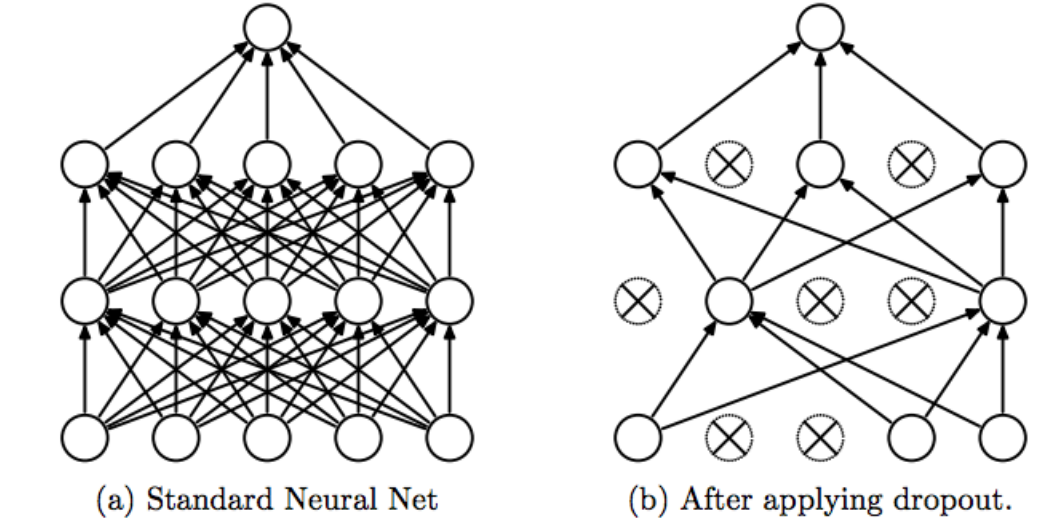

In PyTorch, dropout can be applied to a layer using the nn.Dropout module. This module should be inserted after the linear or convolutional layer in the network, and before the non-linear activation function.

The nn.Dropout takes one argument: the probability of an element to be zeroed. For instance, if we use $ p = 0.5 $, this means that during the forward pass, half of the elements will be set to zero. In general, we set the probability to a value between 0.1 and 0.5.

**Important note:** Dropout should only be used during training mode and not in the test or validation phase, since it would make the model weaker. This is simple done by remembering to set the model to train or eval mode: the Dropout layer will then adjust its behavior automatically.

### Implementing a pooling

3. **Pooling** is a technique used in convolutional neural networks (CNNs) to reduce the spatial dimensions of an image while retaining important information. This allows the network to focus on the most important features and reduces the computation required for larger images. In PyTorch, the most commonly used pooling layer is nn.MaxPool2d, which performs max pooling.

Do note however, that there are different types of pooling layers, all worth trying, including:
- Max pooling: Selects the maximum value from the window,
- Average pooling: Takes the average of all values in the window,
- Sum pooling: Takes the sum of all values in the window.

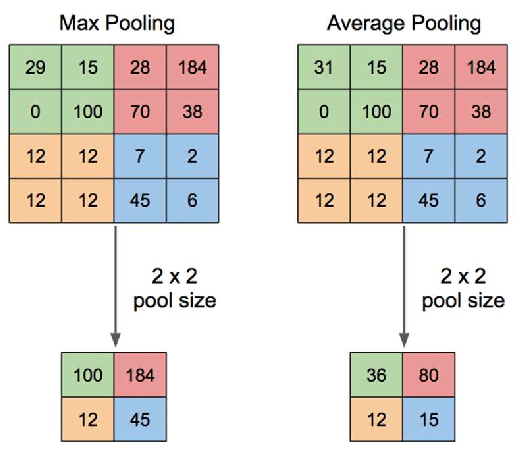

In [17]:
# Seeing the effect of some pooling layers on data
# Open the image and convert it to grayscale
im = Image.open('flower.jpg').convert('L')
# Convert the image to a Tensor
im_tensor = torch.from_numpy(np.array(im)).float().reshape(1, 459, 612)
print(im_tensor.shape)

# Define the pooling layers
max_pool = nn.MaxPool2d(kernel_size = 2, stride = 2)
avg_pool = nn.AvgPool2d(kernel_size = 2, stride = 2)
sum_pool = nn.AdaptiveAvgPool2d(output_size = (229, 306))

# Apply the pooling layers to the image tensor
img_max_pool = max_pool(im_tensor)
img_avg_pool = avg_pool(im_tensor)
img_sum_pool = sum_pool(im_tensor)

# Print the shapes of the pooled images
print(img_max_pool.shape)
print(img_avg_pool.shape)
print(img_sum_pool.shape)

torch.Size([1, 459, 612])
torch.Size([1, 229, 306])
torch.Size([1, 229, 306])
torch.Size([1, 229, 306])


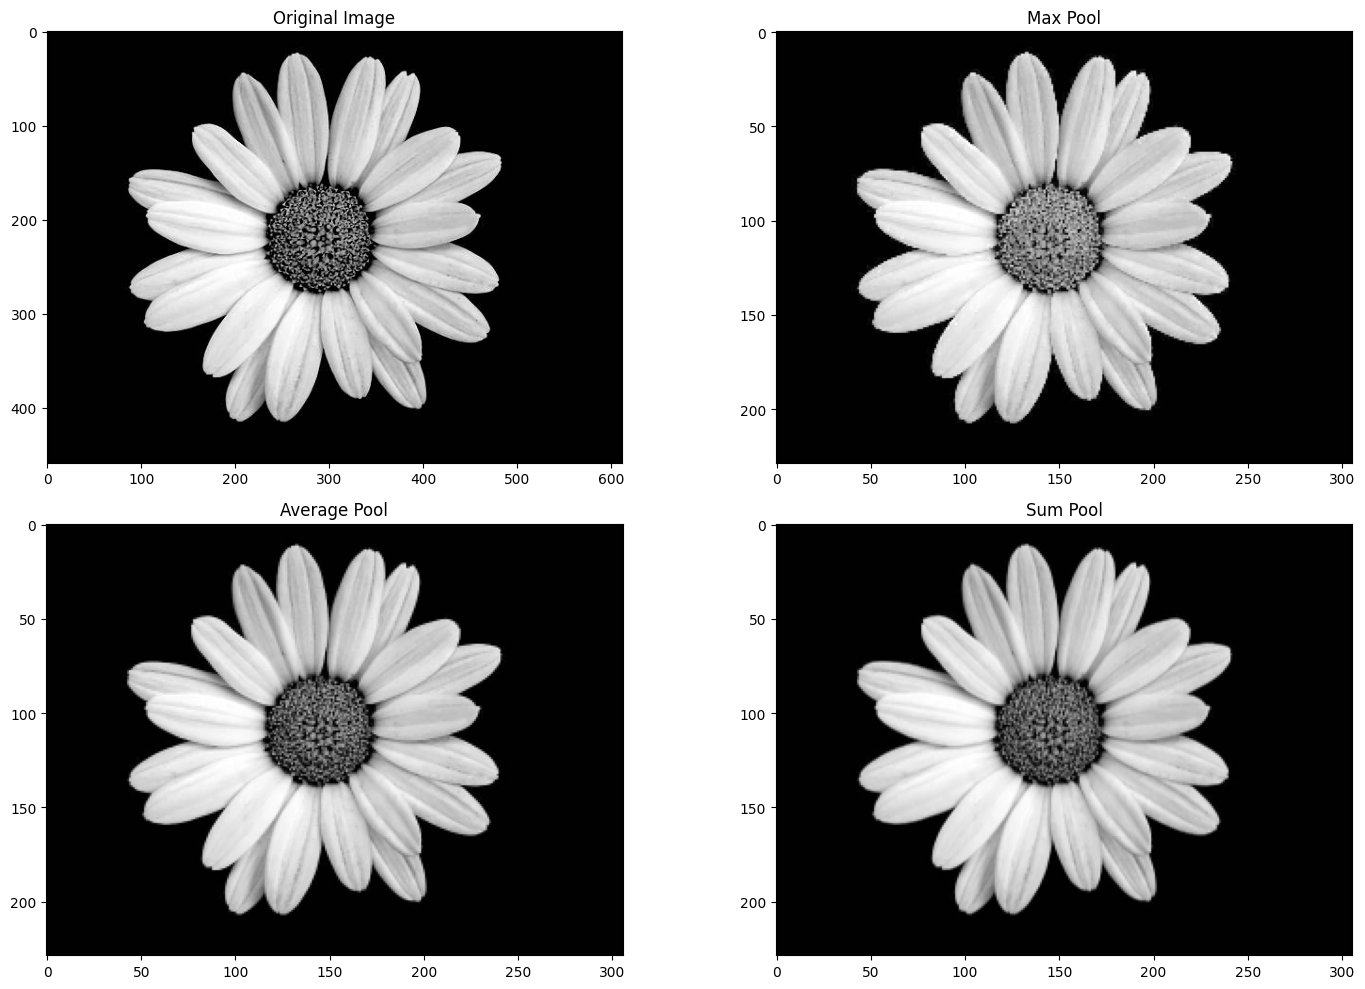

In [18]:
# Display all
fig, axes = plt.subplots(2, 2, figsize = (15, 10))

# Display the images
axes[0, 0].imshow(im_tensor[0], cmap = 'gray')
axes[0, 0].set_title('Original Image')
axes[0, 1].imshow(img_max_pool[0], cmap = 'gray')
axes[0, 1].set_title('Max Pool')
axes[1, 0].imshow(img_avg_pool[0], cmap = 'gray')
axes[1, 0].set_title('Average Pool')
axes[1, 1].imshow(img_sum_pool[0], cmap = 'gray')
axes[1, 1].set_title('Sum Pool')

# Adjust the layout
plt.tight_layout()

# Show the figure
plt.show()

### Assembling all of them at once in our previous CNN

Combining the previous concepts, we will rewrite our CNN model, so that it now has
- 2D or 1D batchnorms after each Conv2d and Linear layer,
- Dropout2d or Dropout after each Conv2d and Linear layer,
- A single Max Pooling 2D after the last Conv2d layer with a kernel of size $ 2 \times 2 $.

We leave the training of said model as extra practice for the students

In [7]:
class MNIST_CNN_all(nn.Module):
    def __init__(self):
        super(MNIST_CNN, self).__init__()
        # Two convolutional layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size = 3, stride = 1, padding = 1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size = 3, stride = 1, padding = 1)
        # Two fully connected layers
        self.fc1 = nn.Linear(64*28*28, 128) # 64*28*28 = 50176
        self.fc2 = nn.Linear(128, 10)
        # Batch normalization layers
        self.batch_norm1 = nn.BatchNorm2d(32)
        self.batch_norm2 = nn.BatchNorm2d(64)
        self.batch_norm3 = nn.BatchNorm1d(128)
        # Dropout layers
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.dropout3 = nn.Dropout(0.25)

    def forward(self, x):
        # Pass input through first convolutional layer
        x = self.conv1(x)
        x = F.relu(x)
        x = self.batch_norm1(x)
        x = self.dropout1(x)
        # Pass output of first conv layer through second convolutional layer
        x = self.conv2(x)
        x = F.relu(x)
        x = self.batch_norm2(x)
        x = self.dropout2(x)
        x = F.max_pool2d(x, 2)
        # Flatten output of second conv layer
        x = x.view(-1, 64*28*28)
        # Pass flattened output through first fully connected layer
        x = self.fc1(x)
        x = F.relu(x)
        x = self.batch_norm3(x)
        x = self.dropout3(x)
        # Pass output of first fully connected layer through second fully connected layer
        x = self.fc2(x)
        return x

### What's next?

In the next notebook, we will briefly discuss the concept of data augmentation.